In [11]:
import numpy as np
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import librosa

import stft

In [2]:
wave_data, sr = librosa.load('./audio/sample.wav')

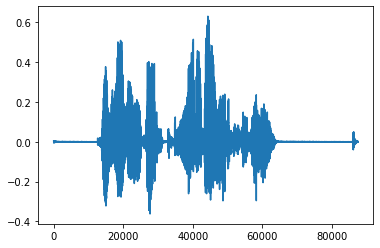

In [3]:
plt.plot(wave_data)

In [4]:
# t = np.arange(0, len(wave_data) / sr, 1/sr)

# # 音声波形の中心部分（定常部）を切り出す
# center = len(wave_data)//2 #　中心のサンプル番号
# cuttime = 0.04 # 秒
# x = wave_data[int(center - cuttime / 2 * sr):int(center + cuttime / 2 * sr)]
# time = t[int(center - cuttime/2*sr): int(center + cuttime/2*sr)]

# plt.plot(time * 1000, x)
# plt.xlabel("time [ms]")
# plt.ylabel("amplitude")
# plt.show()

In [5]:
x = wave_data.copy()

In [7]:
N = 2024
# N = len(x)
# hamming = np.hamming(len(x))
# x = x * hamming

In [19]:
# spec = np.abs(np.fft.fft(x, N))[:N//2]
spec = stft.faster_stft(x, N, 0.5)[:N//2]
# fscale = np.fft.fftfreq(N, d=1./sr)[:N//2]

In [20]:
# plt.plot(fscale, spec)

In [21]:
def hz2mel(f, f0=1000):
    m0 = 1000 / np.log(1000/f0 + 1)
    return m0*np.log(f/f0 + 1)

def mel2hz(m, f0=1000):
    m0 = 1000 / np.log(1000/f0 + 1)
    return f0*(np.exp(m/m0) - 1)

In [22]:
def mel_filter_bank(sr, data_size, bank_size):
    mel_max = hz2mel(sr/2)
    
    n_max = data_size//2
    
    df = sr/data_size
    
    dmel = mel_max/(bank_size+1)
    mel_centers = np.arange(1, bank_size+1) * dmel
    f_centers = mel2hz(mel_centers)
    
    idx_centers = np.round(f_centers / df)
    start_idx = np.hstack(([0], idx_centers[0:bank_size - 1]))
    end_idx = np.hstack((idx_centers[1:bank_size], [n_max]))
    
    filter_bank = np.zeros((bank_size, n_max))
    for c in range(0, bank_size):
        inc = 1./(idx_centers[c]-start_idx[c])
        for i in np.arange(start_idx[c], idx_centers[c]):
            filter_bank[c, int(i)] = (i-start_idx[c])*inc
            
        dec = 1./(end_idx[c] - idx_centers[c])
        for i in np.arange(idx_centers[c], end_idx[c]):
            filter_bank[c, int(i)] = 1.0 - ((i - idx_centers[c]) * dec)

    return filter_bank, f_centers

In [23]:
bank_size = 20
df = sr/N
filter_bank, f_centers = mel_filter_bank(sr, N, bank_size)

In [24]:
# for c in np.arange(0, bank_size):
#     plt.plot(np.arange(0, N/2)*df, filter_bank[c])

In [27]:
mel_spec = np.dot(filter_bank, spec)

In [28]:
# plt.figure(figsize=(13, 5))
# plt.plot(fscale, 10* np.log10(spec), label='Original Spectrum')
# plt.plot(f_centers, 10 * np.log10(mel_spec), "o-", label='Mel Spectrum')

In [33]:
mel_spec_db = librosa.amplitude_to_db(mel_spec)
ceps = dct(mel_spec_db, axis=0)
mfcc = ceps[:13]

In [34]:
print(mfcc)

[[-1.28877350e+03 -1.72569743e+03 -1.85987939e+03 ... -2.00206185e+03
  -1.90854564e+03 -1.25214214e+03]
 [-2.92773835e+01  7.53543986e+01  4.70758894e+01 ...  8.63724223e+01
   4.96365206e+01  5.73324418e+01]
 [ 8.83072761e+01  5.59811664e+01  7.83460553e+01 ... -1.10812094e-01
   8.21240889e+00  1.09630750e+02]
 ...
 [-2.37910184e+01  1.70045312e+00 -5.97565449e+01 ...  2.54957533e+01
   1.15317750e+00 -1.80331394e+01]
 [-2.77625329e+01  2.39684640e+00 -3.89702632e+01 ...  3.74894227e+01
  -1.75572161e+01 -1.66051095e+01]
 [-7.00056117e-01 -3.13585987e+01 -6.60070490e+01 ... -1.37669411e+01
  -5.76606880e+01  2.94252539e+01]]


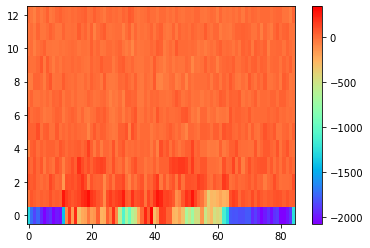

In [36]:
plt.imshow(mfcc, cmap='rainbow', aspect='auto', origin='lower')
plt.colorbar()

In [68]:
def calc_delta(X, width=2):
#     X = np.pad(X, ((0,0), (width+1, width+1)), 'edge')
    
    k = np.arange(-width, width+1)
    _sum = np.sum(k**2)
    
    comp = []
    for i in range(width, X.shape[1]+width):
        try:
            comp.append(np.sum(k*X[:, i-width:i+width+1], axis=1))
        except ValueError:
            break
    comp = np.array(comp).T
    
    delta = comp/_sum
    
    return delta

In [69]:
dmfcc = calc_delta(mfcc)

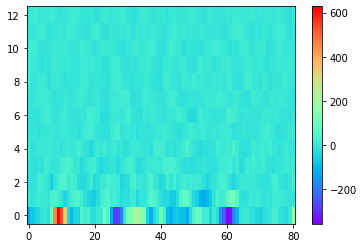

In [71]:
plt.imshow(dmfcc, cmap='rainbow', aspect='auto', origin='lower')
plt.colorbar()

In [72]:
ddmfcc = calc_delta(dmfcc)

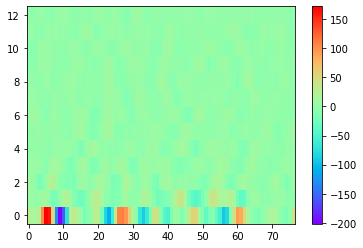

In [73]:
plt.imshow(ddmfcc, cmap='rainbow', aspect='auto', origin='lower')
plt.colorbar()